In [1]:
import numpy as np
import random as rd
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider
import matplotlib.cm as cm
import scipy as SP
from PIL import Image
import threading
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


In [2]:
class Environment():
    
    #fields:
    #a grid of size defined by parameter
    #b, a tuple repsenting the delivery location
    #a, a tuple representing the package location
    #size, an int representing the horizontal and vertical dimensions of the grid
    def __init__(self, size:int, a = None):
        self.size = size
        self.b = (size-1, size-1)
        self.grid, self.a = self.setup_grid(size, a)
        self.reward_pickup = 100
        self.reward_deliver = 100
        self.reward_move = -1

    #method to set up the original grid including a location
    def setup_grid(self, size, a):
        grid = np.zeros((size,size))
        if a is None:
            x, y = rd.randint(0, size-1), rd.randint(0, size-1)
            while (x,y) == self.b:
                x, y = rd.randint(0, size-1), rd.randint(0, size-1)
            grid[x,y] = 1  #A represented by 1
        else:
            x,y=a
            grid[x,y] = 1
        grid[size-1,size-1] = 2  #B represented by 2
        return grid, (x,y)
    
    #method to add start location of agent to grid as well
 #TODO: consider whether to initialise agent as part of environment initialisation
    def set_agent_start(self, agent):
        self.agent_coords = (agent.x, agent.y)
    
    #Method which updates the location of the agent on the grid. Currently just zeroes whatever it landed on - can include other logic instead
    def move_agent(self, agent_move):
        x, y = self.agent_coords
        self.grid[x,y] = 0
        self.agent_coords = agent_move[0] , agent_move[1]
        self.grid[agent_move[0] , agent_move[1]] = -1
        
    def plot_grid(self):
        # Create a figure and axis with a white background
        fig, ax = plt.subplots()
        ax.set_facecolor('white')  # Set background color to white
        
        # Plot the grid
        ax.imshow(np.array([[0]]), cmap="bone", extent=[0, self.size, 0, self.size])
        
        #Load image for the agent
        agent_img = plt.imread('agent.jpg')
        agent_img = Image.open('agent.jpg')
        agent_img = agent_img.resize((100, 100))
        
        #Load image for the package - destination A
        package_img = plt.imread('package.jpg')
        package_img = Image.open('package.jpg')
        package_img = package_img.resize((100, 100))
        
        #Load image for the end destination - destination B
        destinationB_img = plt.imread('destinationB.jpg')
        destinationB_img = Image.open('destinationB.jpg')
        destinationB_img = destinationB_img.resize((100, 100))

        
        for i in range(self.size):
            for j in range(self.size):
                if (i, j) == self.agent_coords:
                    # Display agent image in the cell
                    imagebox = OffsetImage(agent_img, zoom=0.5)
                    ab = AnnotationBbox(imagebox, (j + 0.5, self.size - i - 0.5), frameon=False)
                    ax.add_artist(ab)
                elif (i,j) == self.a:
                    # Display package image in the cell
                    imagebox = OffsetImage(package_img, zoom=0.5)
                    ab = AnnotationBbox(imagebox, (j + 0.5, self.size - i - 0.5), frameon=False)
                    ax.add_artist(ab)
                elif (i,j) == self.b:
                    # Display destination image in the cell
                    imagebox = OffsetImage(destinationB_img, zoom=0.5)
                    ab = AnnotationBbox(imagebox, (j + 0.5, self.size - i - 0.5), frameon=False)
                    ax.add_artist(ab)
                else:
                    ax.text(j + 0.5, self.size - i - 0.5, self.grid[i, j], ha='center', va='center', fontsize=20, color='white')
        
        # Set axis properties
        ax.set_xlim(0, self.size)
        ax.set_ylim(0, self.size)
        ax.set_xticks(np.arange(self.size) + 1)
        ax.set_yticks(np.arange(self.size) + 1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(True, linewidth=2, color='white')
        
        # Set title
        ax.set_title("5x5 Grid Visualization")
        
        # Show the plot
        plt.show()


In [3]:
#An agent class. Currently barebones
class Agent():
    def __init__(self, environ, opts):
        self.environ = environ
        self.reset_agent()
        self.opts = opts
        

    # choose the best action based on the greedy policy on Q-values
    # filed qmat = Q-matrix of size n*n*options where n=grid_size, options=actions
    def choose_best_option(self, qmat):
        if self.collected == 0:
            state_qs = qmat[self.x-self.environ.a[0] + self.environ.size-1,
                            self.y-self.environ.a[1] + self.environ.size-1,
                            self.collected] # 1*1*options
        else:
            state_qs = qmat[self.x-self.environ.b[0] + self.environ.size-1,
                            self.y-self.environ.b[1] + self.environ.size-1,
                            self.collected] # 1*1*options
        action = np.argmax(state_qs) # choose action based on greedy policy where 0=up, 1=down, 2=left, 3=right
        return action

    #Ensure that moves
    
    def move(self, direction):

        if direction == self.opts[0]:
            if self.x-1 >= 0:
                self.x = self.x-1
        if direction == self.opts[1]:
            if self.x+1 < self.environ.size:
                self.x = self.x+1
        if direction == self.opts[2]:
            if self.y-1 >= 0:
                self.y = self.y-1
        if direction == self.opts[3]:
            if self.y+1 < self.environ.size:
                self.y=self.y+1
        
        if self.collected == 0:
            if (self.x, self.y) == self.environ.a:
                self.collected = 1
                reward = self.environ.reward_pickup
            else:
                reward = self.environ.reward_move
        
        else:
            if (self.x, self.y) == self.environ.b:
                self.end_episode = 1
                reward = self.environ.reward_deliver
            else:
                reward = self.environ.reward_move

        return (self.x, self.y, self.collected), reward, self.end_episode
    
    def reset_agent(self):
        self.x, self.y = rd.randint(0, self.environ.size-1), rd.randint(0, self.environ.size-1)
        while ((self.x, self.y) == (self.environ.a or self.environ.b)):
            self.x, self.y = rd.randint(0, self.environ.size-1), rd.randint(0, self.environ.size-1)
        self.collected = 0
        self.end_episode = 0

    
#Class to store hyperparameters
class Hypers():
    def __init__(self, eps, gamma, alpha, steps_per_ep, total_iter):
        self.eps = eps
        self.gamma = gamma
        self.alpha = alpha
        self.steps_per_ep = steps_per_ep
        self.total_iter = total_iter

##Method to initiate agent coordinates should go in setup method since both the Environment and the Agent need to know
#Or we need a hierarchy - consult w/ group


## Q Learn Notes

Rewards come from the environment, agent has values on states that it figures out from the rewards that the environment offers it.

Game has multiple episodes (like, tens of thousands).

Episode has multiple (hundreds?) timesteps. At each episode, we'll have a different location of A from all 24 possible states.

Q table learned across all 24 A locations, 25 agent locations, 4 possible actions, and the pre/post plant situation.

So in total 24 * 25 * 2 states, and four possible actions in each state.

4800 state-action space in total for this toy example.

#### SPECULATIVELY;

If we're constructing this Q-table and using the Bellman equation to backpropagate the rewards from end-state into the Q table, we are effectively "learning" a table which tells us what future rewards are going to be in future states. This lets us, in our _current_ state, choose the action which will best be producing future rewards. So our first near empty Q table will have the agent wander around effectively randomly.


Start with a fixed A and fixed B, to see if you CAN actually learn the Q values. Only THEN do we change to a dynamic location of A.

In [4]:
class QL:
    def __init__(self, env_size, agent_opts, hypers):
        self.env_size = env_size
        self.agent_opts = agent_opts
        self.hypers = hypers
        self.qmat = np.zeros([2*(env_size-1)+1, 2*(env_size-1)+1, 2, len(agent_opts)])
        self.training_history = []

    def train(self, save_every = 1000):
        for i in range(self.hypers.total_iter):
            # Create a new environment and agent for each iteration
            env = Environment(size=self.env_size)
            agent = Agent(env, self.agent_opts)
            env.set_agent_start(agent)
            agent.reset_agent()

            for s in range(self.hypers.steps_per_ep):
                # Choose between explore and exploit (epsilon-greedy)
                if rd.random() < self.hypers.eps:
                    action = rd.randint(0, len(self.agent_opts)-1)
                else:
                    action = agent.choose_best_option(self.qmat)

                if agent.collected == 0:
                    state = (agent.x-env.a[0] + self.env_size-1, agent.y-env.a[1] + self.env_size-1, agent.collected)
                else:
                    state = (agent.x-env.b[0] + self.env_size-1, agent.y-env.b[1] + self.env_size-1, agent.collected)

                # Perform agent's action and receive new position, reward, and end of episode flag
                new_agent_pos, reward, end_episode = agent.move(self.agent_opts[action])
                if agent.collected == 0:
                    next_state = (new_agent_pos[0]-env.a[0] + self.env_size-1, new_agent_pos[1]-env.a[1] + self.env_size-1, agent.collected)
                else:
                    next_state = (new_agent_pos[0]-env.b[0] + self.env_size-1, new_agent_pos[1]-env.b[1] + self.env_size-1, agent.collected) 

                # Determine the best action in the next state
                next_action = np.argmax(self.qmat[next_state])

                
                # Update Q-values using Q-learning equation
                self.qmat[state][action] += self.hypers.alpha * (reward + (self.hypers.gamma * (self.qmat[next_state][next_action])) - self.qmat[state][action])

                if end_episode == 1:
                    break
            #Log reward value to training history
            self.training_history.append(reward)

            #save the qmatrix for later operation
            if i%save_every == 0:
                self.save_qmat(f"logs/episode{s}training.npy")
        return self.qmat
    
    def load_qmat(self, filename):
        self.qmat = np.load(filename)
     
    #method saving qmatrix to npy file for later testing
    def save_qmat(self, name):
        np.save(name, self.qmat)



In [5]:
# Train

env_size = 5  # Set your environment size
opts = ["up", "down", "left", "right"]
hypers = Hypers(
    eps = 0.4, 
    gamma = 0.8,
    alpha = 0.01,
    steps_per_ep = 100,
    total_iter = 50000
    eps_decay_rate = 1000
)
ql = QL(env_size, opts, hypers)
qmat = ql.train()


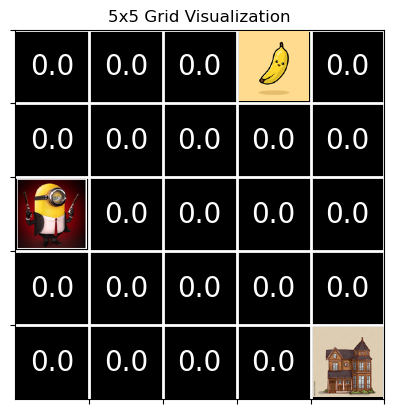

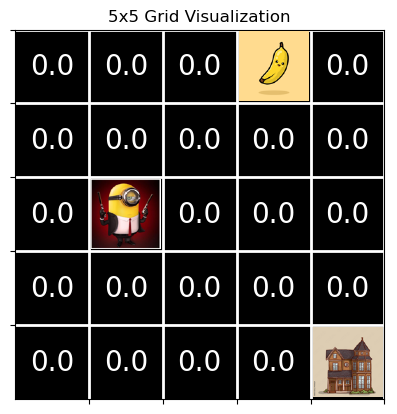

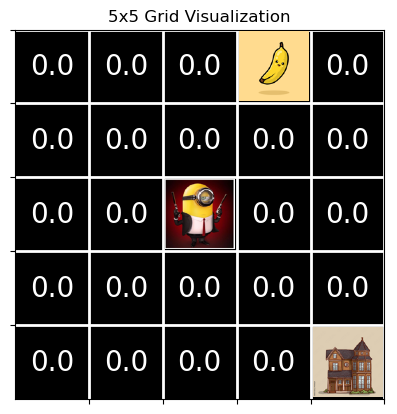

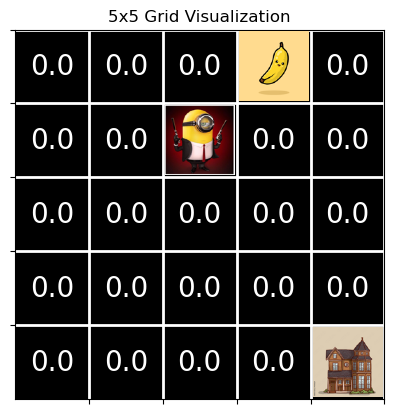

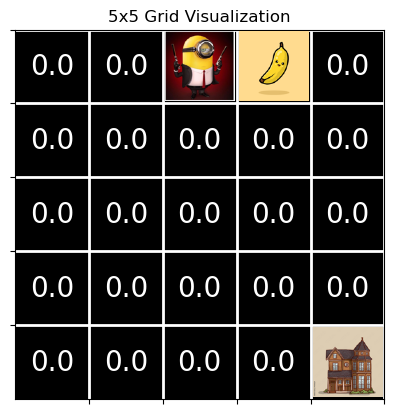

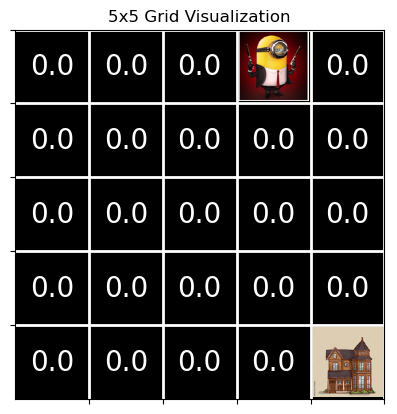

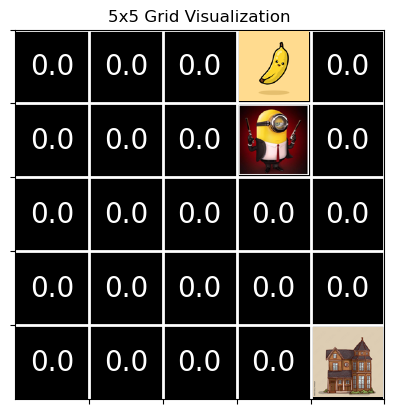

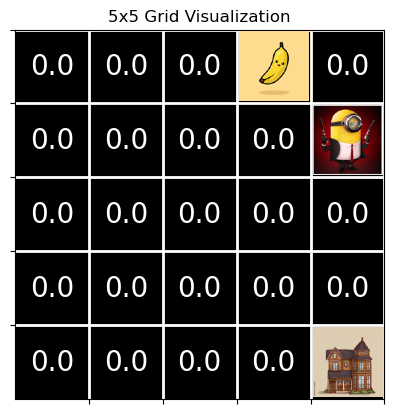

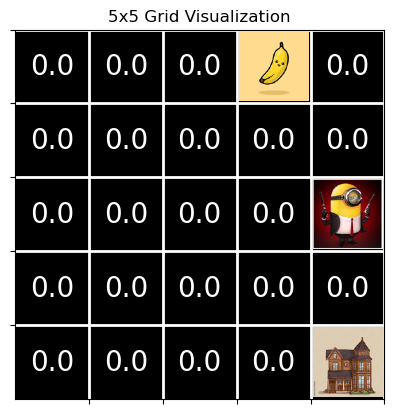

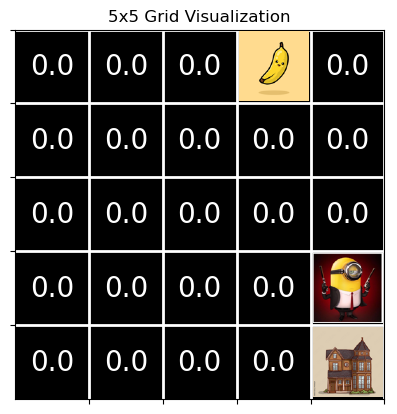

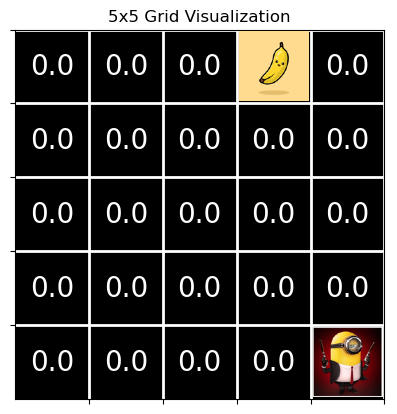

In [7]:
# Test - does not update Q-matrix (qmat)

env = Environment(size = 5)
bond = Agent(env, opts)
env.set_agent_start(bond)

env.move_agent((bond.x, bond.y, bond.collected))
env.plot_grid()
for step in range(20):
    
    if bond.collected == 0:
        state = (bond.x-env.a[0] + env.size-1 , bond.y-env.a[1] + env.size-1 , bond.collected)
    else:
        state = (bond.x-env.b[0] + env.size-1 , bond.y-env.b[1] + env.size-1 , bond.collected)

    action = bond.choose_best_option(qmat)
    
    pos,_,end = bond.move(bond.opts[action])
    env.move_agent(pos) 
    env.plot_grid()
    if end == 1:
        break
